The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install -U --pre mxnet-cu101mkl  # updating mxnet to at least v1.6
!pip install git+https://github.com/d2l-ai/d2l-en # installing d2l


# Natural Language Inference: Using Attention

In the previous section, we introduce the natural language inference task. Given the premise and hypothesis, this task identifies the inference relationship between them, including three types: entailment, contradiction and neutral.

This section will discuss one of the classic tasks of natural language inference: decomposable attention model [1]. In the section `Machine translation`, we applied the attention mechanism in machine translation tasks. For these tasks, we can identify the relationship between words through attention mechanism. Decomposable attention model is enlightened by the function of attention mechanism. According to the decomposable attention model, the inference relationship between two sentences can be inferred from the corresponding relationship among the words, which can be found by the attention mechanism. Back then, this model achieved the highest rate of accuracy in Stanford natural language inference dataset, whose number of parameters are also significantly lower than other complicated models.

Firstly, input packages and modules needed by the experiment.

In [1]:
import d2l
import mxnet as mx

from mxnet import autograd, gluon, init, np, npx
from mxnet.contrib import text
from mxnet.gluon import nn

npx.set_np()

## Model

Before introducing the model, let’s look at the following three sentences:

- Bob is in his room, but because of the thunder and lightning outside, he cannot sleep.
- Bob is awake.
- It is sunny outside.

“Cannot sleep” in the first sentence and “awake” in the second sentence have the same meaning. Despite the complicated structures of the first sentence, we can also easily reach the conclusion: the second sentence is entailed in the first sentence. Similarly, as “thunder and lighting” in the first sentence and “sunny” in the third sentence are mutually exclusive, we can conclude the first sentence is contradictory to the third sentence.

Based on the above examples, we can find a synonymous or mutually exclusive relationship between the words of premise and hypothesis, which can also conclude the inference relationship between premise and hypothesis. 

Therefore, it naturally occurs to us that we can divide the task of identifying the inference relationship between premise and hypothesis into subproblems. Firstly, establish the relationship between each word of premise and hypothesis. This step is also known as world alignment. Then, compare the alignment relationship of every word pair to identify the inference relationship between premise and hypothesis. It also involves the three basic steps of the decomposable attention model: attention, comparison and aggregation.

### Attend

The text sequence of premise consists of $l_A$ words. The text sequence of hypothesis consists of $l_B$ words. The dimension of word embedding is $d$. In the attention process,  the premise $\boldsymbol{A}= (a_1,\ldots,a_{l_A}) \in \mathbb{R}^{l_A \times d}$ and hypothesis $\boldsymbol{B} = (b_1,\ldots,b_{l_B}) \in \mathbb{R}^{l_B \times d}$ are input respectively. $a_i$ and $b_i$ represent the word embedding of Premise A and Hypothesis B.

In the previous section of `attention mechanism`, for the seq2seq model, attention mechanism can learn about the intimate connection between the tabs of target sequence and source sequence, which is also a type of word alignment relationship in essence. For this reason, we can use the attention mechanism to learn about the word alignment relationship.

Firstly, we need to calculate the unnormalized attention weight matrix $e$ between  ${a_1,\ldots,a_{l_A}}$  and ${b_1,\ldots,b_{l_B}}$ . In other words, after the feedforward network calculation of $a_i$ and $b_j$, and then calculate the attention of inner product.

$$
e_{ij} = F(a_i)^\top F(b_j)
$$
Next, we need to operate the sentence $A$. In this case, $\beta_i$ is the alignment word corresponding from B to $a_i$. Generally speaking, it is obtained by the weighted array $(b_1,\ldots,b_{l_B})$ of $a_i$. This step is known as soft alignment. Similarly, soft alignment is also necessary for sentence $B$.
$$
\beta_i = \sum_{j=1}^{l_B}\frac{\exp(e_{ij})}{ \sum_{k=1}^{l_B} \exp(e_{ik})} b_j,
$$

$$
\alpha_j = \sum_{i=1}^{l_A}\frac{\exp(e_{ij})}{ \sum_{k=1}^{l_A} \exp(e_{kj})} a_i,
$$

In [2]:
# Defining feedforward network
def ff_layer(out_units, flatten=True):
    m = nn.Sequential()
    m.add(nn.Dropout(0.2))
    m.add(nn.Dense(out_units, activation='relu', 
                   flatten=flatten))
    m.add(nn.Dropout(0.2))
    m.add(nn.Dense(out_units, in_units=out_units, activation='relu', 
                   flatten=flatten))
    return m
    
class Attend(nn.Block):
    def __init__(self, hidden_size, **kwargs):
        super(Attend, self).__init__(**kwargs)
        self.f = ff_layer(out_units=hidden_size, flatten=False)
            
    def forward(self, a, b):
        # Feed two sentences into a feedforward neural network. The shape of 
        # outputs is (batch size, number of words, number of hidden units)
        # with dimensions (batch size, sentence length, number of hidden units)
        f_a = self.f(a)
        f_b = self.f(b)
        # Calculate Attention Score e. The shape of outputs is
        # (batch size, number of words, number of hidden units)
        e = npx.batch_dot(f_a, f_b, transpose_b=True)
        # Perform a soft alignment operation on sentence A to align sentence B
        # to sentence A. The shape of outputs is
        # (batch size, number of words in sentence 1, number of hidden units)
        beta = npx.batch_dot(npx.softmax(e), b)
        # Perform a soft alignment operation on sentence B to align sentence A
        # to sentence B. The shape of outputs is
        # (batch size, number of words in sentence 2, number of hidden units)
        alpha = npx.batch_dot(npx.softmax(e.transpose(0, 2, 1)), a)
        return beta, alpha

After this step, we convert this issue into comparing word pairs after alignment.

### Compare
In the attention process, soft alignment is achieved between every word of premise and hypothesis. In the comparison process, we need to compare all the soft alignment relationships. We also need to represent every word with $a_i$ and represent aligned word with $\beta_i$. Then, the feed-forward network conversion is conducted. The converted vectors are known as comparison vectors. Likewise, we also implement the same step for every word $b_i$ and the aligned word $\alpha_i$.


$$
v_{1,i} = G([a_i, \beta_i])
$$

$$
v_{2,j} = G([b_i, \alpha_i])
$$

In [3]:
class Compare(nn.Block):
    def __init__(self, hidden_size, **kwargs):
        super(Compare, self).__init__(**kwargs)
        self.g = ff_layer(out_units=hidden_size, flatten=False)

    def forward(self, a, b, beta, alpha):
        # Concatenate each word and its aligned word representation and feed
        # it through a feedforward network
        v1 = self.g(np.concatenate([a, beta], axis=2))
        v2 = self.g(np.concatenate([b, alpha], axis=2))
        return v1, v2

### Aggregate

Now we have two sets of comparison vectors. In this step, we need to convert the set of comparison vectors to representation vectors of sentences. A relatively simple way is to regard the average value of vectors as the representation vectors of sentences.

$$
v_1 = \sum_{i=1}^{l_A}v_{1,i}
$$

$$
v_2 = \sum_{j=1}^{l_B}v_{2,j}
$$

Then, we connect the representation vectors of two sentences and classify them through feed-forward network.

$$
\hat{y} = H([v_1, v_2])
$$

In [4]:
class Aggregate(nn.Block):
    def __init__(self, hidden_size, num_class, **kwargs):
        super(Aggregate, self).__init__(**kwargs)
        self.h = ff_layer(out_units=hidden_size, flatten=True)
        self.h.add(nn.Dense(num_class, in_units=hidden_size))
            
    def forward(self, feature1, feature2):
        # Average the vectors in each set as the sentence's representation
        # vector.
        feature1 = feature1.sum(axis=1)
        feature2 = feature2.sum(axis=1)
        # Concatenate the representations of each sentence and classify
        # using a feedforward network.
        yhat = self.h(np.concatenate([feature1, feature2], axis=1))
        return yhat

## The use of decomposable attention model

We combine the above three steps of "attention", "comparison" and "aggregation".

In [5]:
class DecomposableAttention(nn.Block):
    def __init__(self, vocab, embed_size, hidden_size, **kwargs):
        super(DecomposableAttention, self).__init__(**kwargs)
        self.embedding = nn.Embedding(len(vocab), embed_size)
        self.attend = Attend(hidden_size)
        self.compare = Compare(hidden_size)
        self.aggregate = Aggregate(hidden_size, 3)
        
    def forward(self, X):
        premise, hypothesis = X
        a = self.embedding(premise)
        b = self.embedding(hypothesis)
        # Attend
        beta, alpha = self.attend(a ,b)
        # Compare
        v1, v2 = self.compare(a, b, beta, alpha)
        # Aggregate
        yhat = self.aggregate(v1, v2)
        return yhat

### Read dataset

We use the Stanford natural language inference dataset to formulate examples of training set and testing set, as well as define iterators of training set and testing set.

In [6]:
batch_size = 256
train_iter, test_iter, vocab = d2l.load_data_snli(batch_size)

read 549367 examples


read 9824 examples


Create a `DecomposableAttention` instance.

In [7]:
embed_size, hidden_size, ctx = 100, 200, d2l.try_all_gpus()
net = DecomposableAttention(vocab, embed_size, hidden_size)
net.initialize(init.Xavier(), ctx=ctx)

### Training the model

We use the pre-trained word vector as the feature vector of every word. In this case, we load the 100-dimension GloVe vector for every word in vocab. It should be noted that the dimension of the pre-trained word vector needs to agree with embed_size of the embedded layer of established models.

In [8]:
glove_embedding = text.embedding.create(
    'glove', pretrained_file_name='glove.6B.100d.txt')
embeds = glove_embedding.get_vecs_by_tokens(vocab.idx_to_token)
net.embedding.weight.set_data(embeds)

We define the `split_batch_multi_input` function. This function divides and copies multiple small batches of data samples to video memories in ctx variables.

In [9]:
# Saved in the d2l package for later use
def split_batch_multi_inputs(X, y, ctx_list):
    """Split X and y into multiple devices specified by ctx"""
    X = list(zip(*[gluon.utils.split_and_load(feature, ctx_list, even_split=False)
                   for feature in X]))
    return (X, gluon.utils.split_and_load(y, ctx_list, even_split=False))

Now, we can start training.

loss 0.490, train acc 0.807, test acc 0.822
11503.3 examples/sec on [gpu(0), gpu(1)]


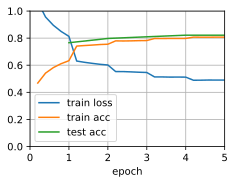

In [10]:
lr, num_epochs = 0.001, 5
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': lr})
loss = gluon.loss.SoftmaxCrossEntropyLoss()
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
               ctx, split_batch_multi_inputs)

### Evaluating the Model

Finally, define the prediction function.

In [11]:
# Saved in the d2l package for later use
def predict_snli(net, premise, hypothesis):
    premise = np.array(vocab[premise],
                       ctx=d2l.try_gpu())
    hypothesis = np.array(vocab[hypothesis],
                          ctx=d2l.try_gpu())
    label = np.argmax(net([premise.reshape((1, -1)),
                           hypothesis.reshape((1, -1))]), axis=1)
    return 'neutral' if label == 0 else 'contradiction' if label == 1 \
            else 'entailment'

Next, trained models are used to infer the relationship between two simple sentences.

In [12]:
predict_snli(net,
        ['a', 'person', 'on', 'a', 'horse', 'jumps', 'over', 'a', 'broken',
         'down', 'airplane', '.'],
        ['a', 'person', 'is', 'training', 'his', 'horse', 'for', 'a',
         'competition', '.'])

'entailment'

## Calculate time complexity

Assume $d$ is the dimension of the hidden layer and $O(d^2)$ is the time complexity of the feed-forward network. For the attention process, $O(l)$ changes of feed-forward network and time complexity $O(ld^2)$ are required. In addition, $O(l^2d)$ is the time complexity to calculate the attention of inner product.The comparison process needs $O(l)$ changes of monolayers and fully connected layers. Hence, $O(ld^2)$.In the process of aggregation, only one hidden layer and multi-layer perceptron are involved. Hence, $O(d^2)$ is the time complexity. Therefore, the overall value of time complexity is $O(l d^2+ l^2 d)$.

## Summary

* Attention mechanism can be used to conduct the soft alignment of words.
* Decomposable attention model converts natural language inference to comparison of words after alignment.


## References

[1] Parikh, A.P., Täckström, O., Das, D., & Uszkoreit, J. (2016). A Decomposable Attention Model for Natural Language Inference. *EMNLP*.

## [Discussions](https://discuss.mxnet.io/t/5518)

![](../img/qr_natural-language-inference-attention.svg)